# $\ell_1$ trend filtering

**Reference:** S.-J. Kim, K. Koh, S. Boyd, and D. Gorinevsky. [*$\ell_1$ Trend Filtering*.](http://stanford.edu/~boyd/papers/l1_trend_filter.html) SIAM Review, 51(2):339-360, 2009.

## Introduction

The problem of estimating underlying trends in time series data arises in a variety of disciplines. The $\ell_1$ trend filtering method produces trend estimates $z$ that are piecewise linear from the time series $y$.

The $\ell_1$ trend estimation problem can be formulated as

$$\text{minimize}~ \frac{1}{2}\|y - z\|_2^2 + \alpha \|Dz\|_1,$$

with variable $z \in \mathbf{R}^q$, problem data $y \in \mathbf{R}^q$, and smoothing parameter $\alpha \geq 0$. Here $D \in \mathbf{R}^{(q-2) \times q}$ is the second difference matrix

$$D = \left[\begin{array}{ccccccc}
1 & -2 &  1 & 0 & \ldots & 0  &0 \\
0 &  1 & -2 & 1 & \ldots & 0 & 0  \\
\vdots & \vdots & \ddots & \ddots & \ddots & \vdots& \vdots \\
0 & 0 & \ldots &1 & -2 & 1 & 0 \\
0 & 0 & \ldots & 0 & 1 & -2 & 1 
\end{array}\right].$$

## Reformulate and Solve Problem

This problem can be written in standard form by letting

$$f_1(x_1) = \frac{1}{2}\|y - x_1\|_2^2, \quad f_2(x_2) = \alpha \|x_2\|_1,$$
$$A_1 = D, \quad A_2 = -I, \quad b = 0,$$

where the variables $x_1 \in \mathbf{R}^q$ and $x_2 \in \mathbf{R}^{q-2}$. We solve an instance where $y$ is a snapshot of the S&P 500 price for $q = 2000$ time steps and $\alpha = 0.01\|y\|_{\infty}$.

In [1]:
import numpy as np
from scipy import sparse
from a2dr import a2dr
from a2dr.proximal import *

# Load time series data: S&P 500 price log.
y = np.loadtxt(open("data/snp500.txt", "rb"), delimiter = ",")
q = y.size
alpha = 0.01*np.linalg.norm(y, np.inf)

# Form second difference matrix.
D = sparse.lil_matrix(sparse.eye(q))
D.setdiag(-2, k = 1)
D.setdiag(1, k = 2)
D = D[:(q-2),:]

# Convert problem to standard form.
prox_list = [lambda v, t: prox_sum_squares(v, t = 0.5*t, offset = y),
             lambda v, t: prox_norm1(v, t = alpha*t)]
A_list = [D, -sparse.eye(q-2)]
b = np.zeros(q-2)

# Solve with A2DR.
a2dr_result = a2dr(prox_list, A_list, b)

# Save solution.
z_star = a2dr_result["x_vals"][0]
print("Solve time:", a2dr_result["solve_time"])
print("Number of iterations:", a2dr_result["num_iters"])

----------------------------------------------------------------------
a2dr v0.2.3.post1 - Prox-Affine Distributed Convex Optimization Solver
                       (c) Anqi Fu, Junzi Zhang
                      Stanford University   2019
----------------------------------------------------------------------
### Preconditioning starts ... ###
### Preconditioning finished.  ###
max_iter = 1000, t_init (after preconditioning) = 7.00
eps_abs = 1.00e-06, eps_rel = 1.00e-08, precond = True
ada_reg = True, anderson = True, m_accel = 10
lam_accel = 1.00e-08, aa_method = lstsq, D_safe = 1.00e+06
eps_safe = 1.00e-06, M_safe = 10
variables n = 3998, constraints m = 1998
nnz(A) = 7992
Setup time: 1.98e-02
----------------------------------------------------
 iter | total res | primal res | dual res | time (s)
----------------------------------------------------
     0| 2.32e+01    3.34e-03     2.32e+01   5.89e-02
   100| 5.27e-04    1.19e-04     5.14e-04   1.58e+00
   200| 5.15e-05    1.85e-05   

## Plot Results

Text(0.5, 0, 'Time')

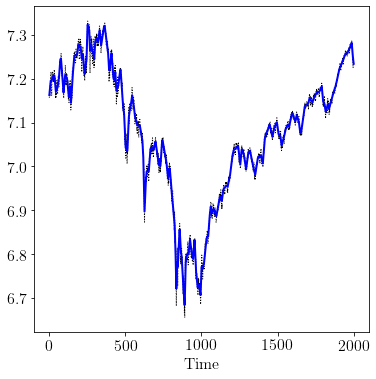

In [2]:
import matplotlib.pyplot as plt

# Show plots inline in ipython.
%matplotlib inline

# Plot properties.
plt.rc("text", usetex = True)
plt.rc("font", family = "serif")
font = {"weight" : "normal",
        "size"   : 16}
plt.rc("font", **font)

# Plot estimated trend with original signal.
plt.figure(figsize = (6, 6))
plt.plot(np.arange(1,q+1), y, "k:", linewidth = 1.0)
plt.plot(np.arange(1,q+1), z_star, "b-", linewidth = 2.0)
plt.xlabel("Time")